In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
import statsmodels.api as sm
from scipy.stats import ttest_1samp, wilcoxon
from tabulate import tabulate

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from pqr.data_preprocessing import get_factor, set_stock_universe
from pqr.portfolios_formation import get_all_quantiles, set_equal_weights, set_value_weights
from pqr.costs import get_fee_costs
from pqr.portfolio_return import get_universe_return, get_portfolio_return, compare_portfolios
from pqr.benchmark import get_benchmark

# План
1. Базовое исследование факторов по отдельности
2. Проверка статистической значимости факторных стратегий
3. Построение факторной стратегии на основе проведенного анализа факторов

# Базовое исследование факторов по отдельности

## Факторы для исследования
* Моментум
* Фактор стоимости - EV/EBITDA
* Фактор качества - ROA
* Фактор низкой волатильности - $\beta$
* Фактор размера - Market Cap

In [3]:
lookings_lags_holdings = [
    (1, 0, 1),
    (3, 0, 3),
    (3, 1, 3),
    (6, 0, 6),
    (9, 0, 9),
    (12, 0, 12)
]
quantile_step = 1 / 3
fee_rate= 0.0005

In [4]:
prices = pd.read_excel('data/price.xlsx', index_col=0, parse_dates=True)

momentum = prices
value = pd.read_excel('data/mults/ev_ebitda.xlsx', index_col=0, parse_dates=True)
quality = pd.read_excel('data/financials/roa.xlsx', index_col=0, parse_dates=True)
low_volatility = pd.read_excel('data/volatility/beta.xlsx', index_col=0, parse_dates=True)
size = pd.read_excel('data/financials/market_cap.xlsx', index_col=0, parse_dates=True)

trading_volume = pd.read_excel('data/liquidity/volume.xlsx', index_col=0, parse_dates=True) * prices

In [5]:
def test_factor(
    factor,
    static,
    looking,
    lag,
    holding,
    prices=prices,
    quatile_step=quantile_step,
    fee_rate=fee_rate,
    add_wml=False,
    bigger_better=True,
    filter_factor=None,
    min_threshold=None,
    only_portfolio_and_benchmark=False
):
    factor = get_factor(factor, static=static, looking_period=looking, lag=lag)
    if filter_factor is not None:
        factor = set_stock_universe(factor, filter_factor, min_threshold=min_threshold)
        
    positions, names = get_all_quantiles(factor, quantile_step=quantile_step, 
                                         holding_period=holding, static=static)
    portfolio = set_equal_weights(positions)
    fee = get_fee_costs(portfolio, fee_rate=fee_rate)
    
    universe_return = get_universe_return(prices)
    portfolio_return = get_portfolio_return(portfolio, universe_return, fee_lists=fee)
    benchmark_return = get_benchmark(prices, factor, universe_return, equal_weights=True)
    
    if add_wml:
        portfolio_return.append((portfolio_return[-1] - portfolio_return[0]) * (-1) ** (not bigger_better))
        names.append('wml')
    
    if not only_portfolio_and_benchmark:
        return compare_portfolios(names, portfolio_return, benchmark_return, prices.index)
    else:
        return portfolio_return, benchmark_return

In [6]:
def full_test_factor(
    factor_name,
    factor,
    static,
    llh=lookings_lags_holdings,
    prices=prices,
    quantile_step=quantile_step,
    fee_rate=fee_rate,
    bigger_better=True
):
    results = []
    for lo, la, h in llh:
        print(f'{factor_name}({lo}-{la}-{h})')
        test_factor(factor, static, lo, la, h, add_wml=True, bigger_better=bigger_better)
        plt.show()

### Моментум

Momentum(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.28 │          0.19 │          -0.32 │  -0.04 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.09 │          0.96 │          -1.23 │  -0.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.49 │          0.76 │           0.43 │  -0.19 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.92 │          1.2  │           0.72 │  -0.2  │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.18 │          0.11 │          -0.37 │  -1.29 │
├────────────────┼───────────────┼───────────────┼──────────

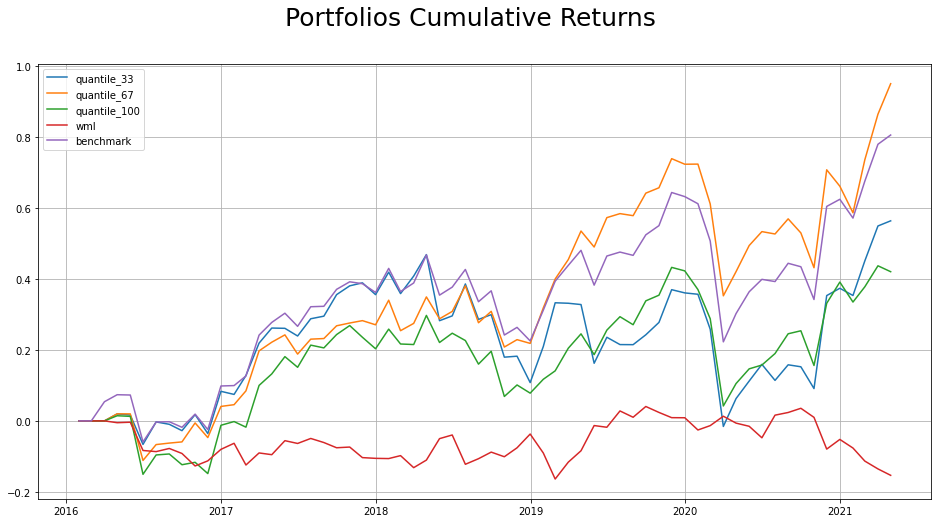

Momentum(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │          0.14 │          0.02 │          -0.24 │  -0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │          0.58 │          0.12 │          -0.89 │  -0.8  │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.65 │          0.59 │           0.42 │  -0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          1.18 │          0.97 │           0.7  │  -0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │          0.2  │         -0    │          -0.27 │  -1.45 │
├────────────────┼───────────────┼───────────────┼──────────

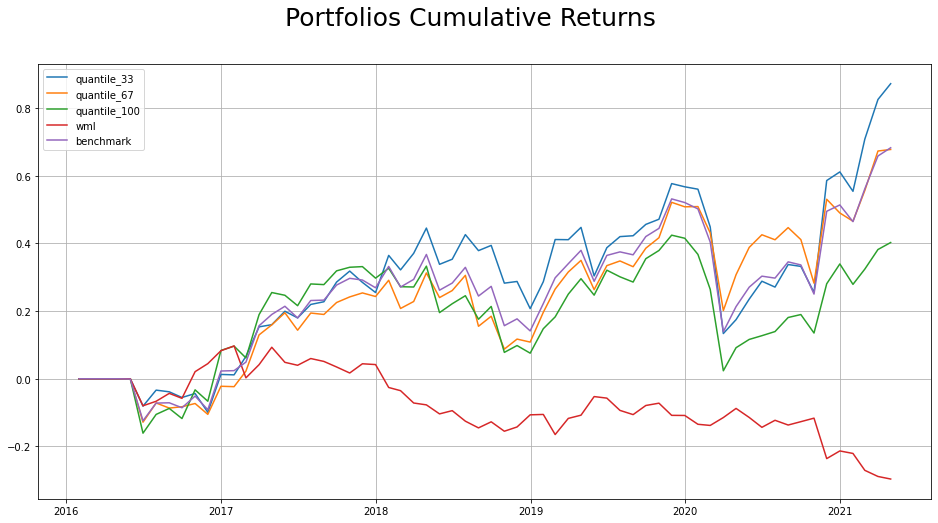

Momentum(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.14 │          0.23 │           0.13 │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.4  │          0.8  │           0.4  │ -0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.61 │          0.69 │           0.61 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.04 │          1.13 │           0.98 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.06 │          0.15 │           0    │ -1.04 │
├────────────────┼───────────────┼───────────────┼────────────────┼─────

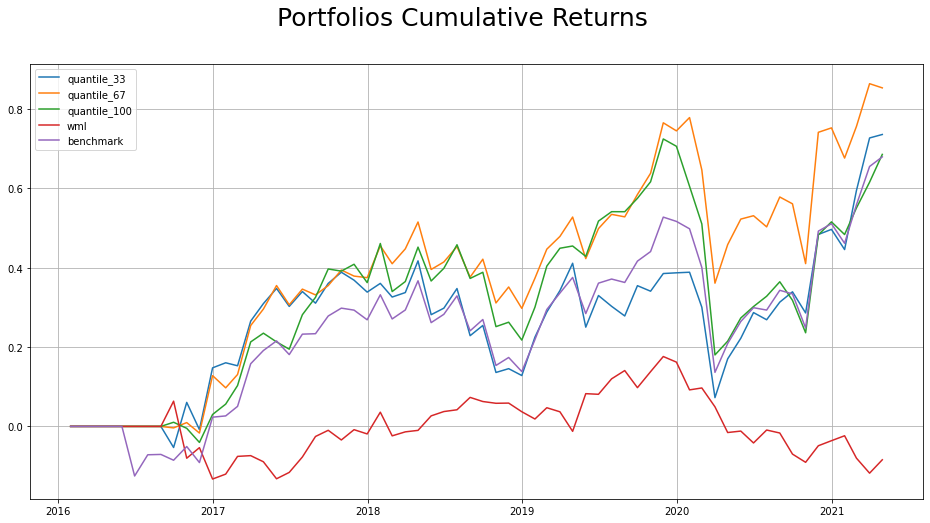

Momentum(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.2  │         -0.04 │           0.19 │  0.4  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.02 │         -0.25 │           0.78 │  0.96 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.56 │          0.64 │           0.78 │  0.21 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.02 │          0.95 │           1.22 │  0.2  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.06 │         -0.13 │           0.14 │ -0.88 │
├────────────────┼───────────────┼───────────────┼────────────────┼─────

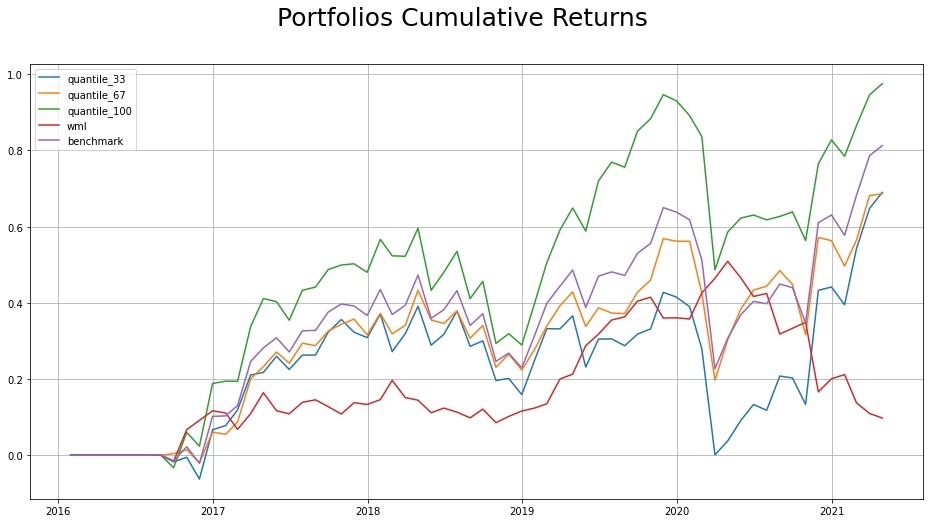

Momentum(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.16 │         -0.14 │           0.17 │  0.01 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.69 │         -0.65 │           0.68 │  0.02 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.74 │          0.55 │           0.74 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.22 │          0.89 │           1.16 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.18 │         -0.15 │           0.12 │ -1.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼─────

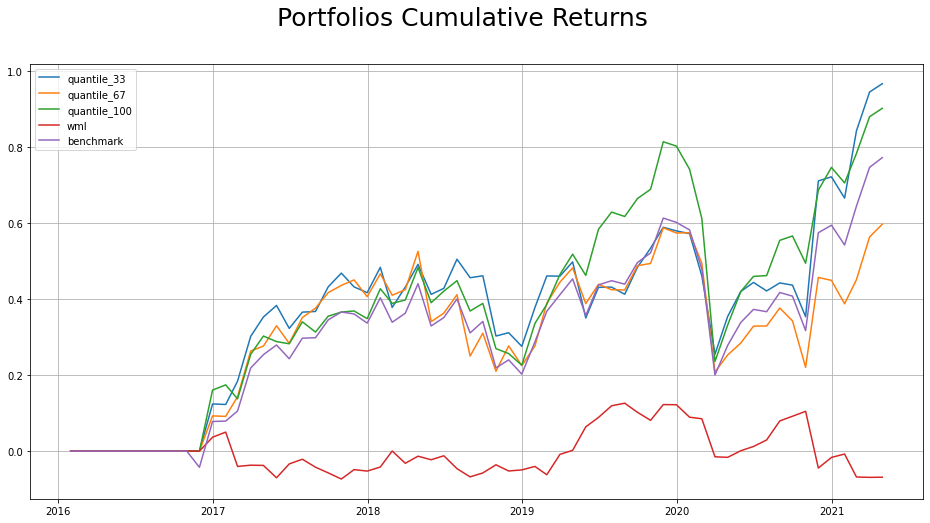

Momentum(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.13 │          0.07 │          -0.2  │ -0.07 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.54 │          0.44 │          -0.82 │ -0.16 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.51 │          0.65 │           0.46 │ -0.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.84 │          0.89 │           0.75 │ -0.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.07 │         -0.02 │          -0.16 │ -1    │
├────────────────┼───────────────┼───────────────┼────────────────┼───

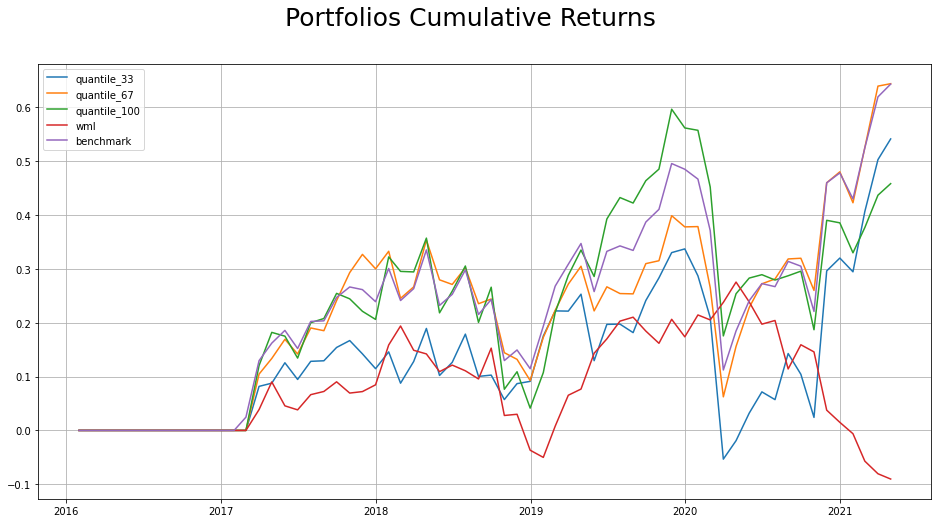

In [7]:
full_test_factor('Momentum', momentum, static=False, bigger_better=True)

Явно видно, что моментум-фактор не очень удачно подходит для портфельного инвестирования на рынке Италии. При некоторых параметрах действительно получается, что компании с наибольшим моментумом лучше индекса, а компании с наименьшим - хуже, однако даже в этом случае не слишком значительные отличия всех 3 портфелей от индекса. WML-портфель имеет околонулевой или отрицательный коэффициент Шарпа (в зависимости от периода наблдения и периода удержания), поэтому можно утверждать, что данный фактор на рынке Италии не работает.

### Фактор стоимости

Value(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.36 │          0.06 │           0.41 │  -0.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.24 │          0.23 │           1.58 │  -1.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.42 │          0.64 │           0.86 │  -0.44 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.84 │          1.05 │           1.36 │  -0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.21 │         -0    │           0.31 │  -1.57 │
├────────────────┼───────────────┼───────────────┼─────────────

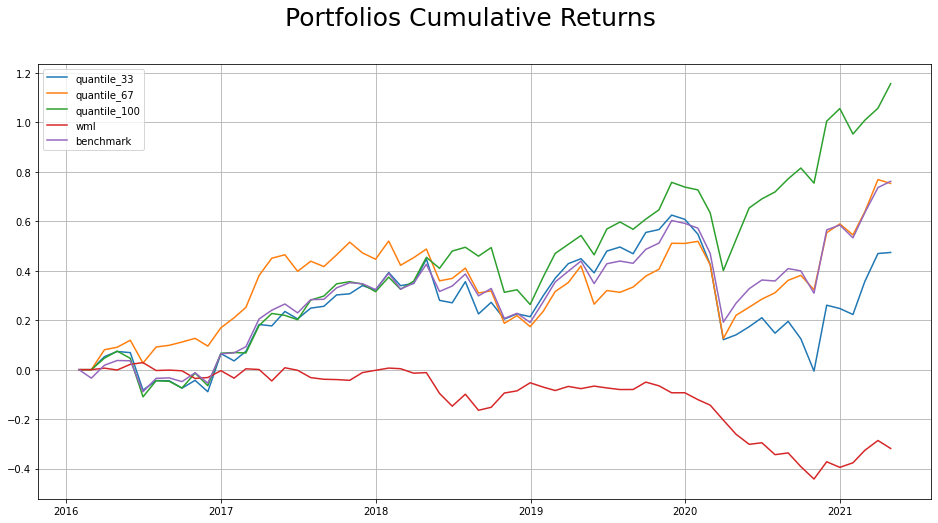

Value(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.1  │          0.04 │           0.75 │  -0.85 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -0.27 │          0.13 │           2.55 │  -1.73 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.51 │          0.59 │           1.06 │  -0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          1    │          0.9  │           1.56 │  -0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.01 │         -0.1  │           0.56 │  -1.57 │
├────────────────┼───────────────┼───────────────┼─────────────

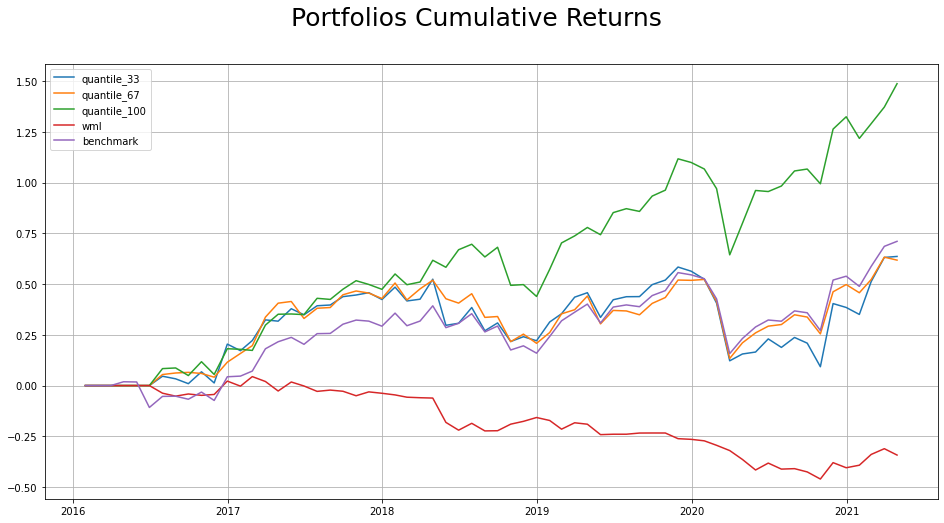

Value(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.05 │         -0.04 │           0.84 │  -0.89 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -0.13 │         -0.13 │           2.96 │  -1.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.52 │          0.52 │           1.12 │  -0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          1.03 │          0.81 │           1.61 │  -0.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │          0.06 │         -0.17 │           0.64 │  -1.56 │
├────────────────┼───────────────┼───────────────┼─────────────

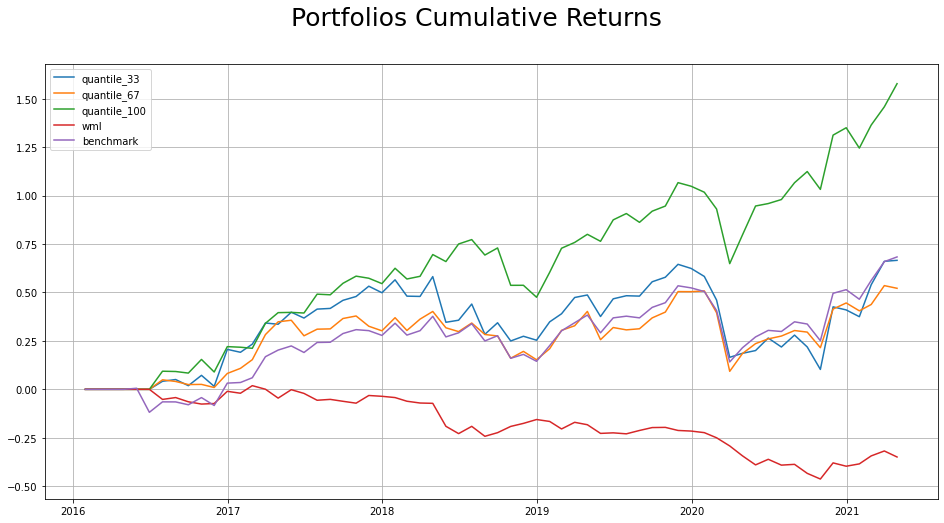

Value(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.36 │         -0.11 │           0.24 │  -0.6  │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.29 │         -0.5  │           1.03 │  -1.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.5  │          0.63 │           0.86 │  -0.49 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.91 │          0.95 │           1.36 │  -0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.26 │         -0.21 │           0.2  │  -1.62 │
├────────────────┼───────────────┼───────────────┼─────────────

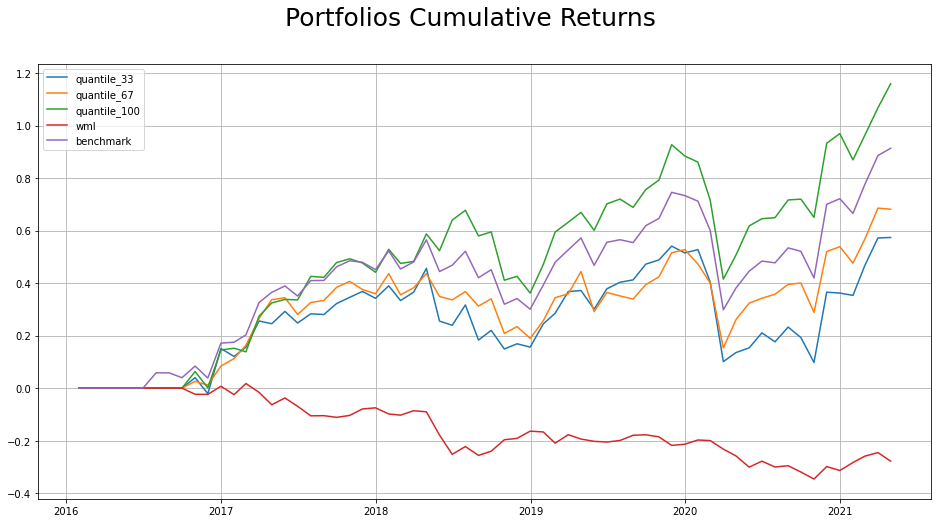

Value(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.45 │         -0.02 │           0.19 │  -0.64 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.31 │         -0.06 │           0.62 │  -1.47 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.36 │          0.61 │           0.74 │  -0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.61 │          0.9  │           1.12 │  -0.51 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.47 │         -0.18 │           0.05 │  -1.59 │
├────────────────┼───────────────┼───────────────┼─────────────

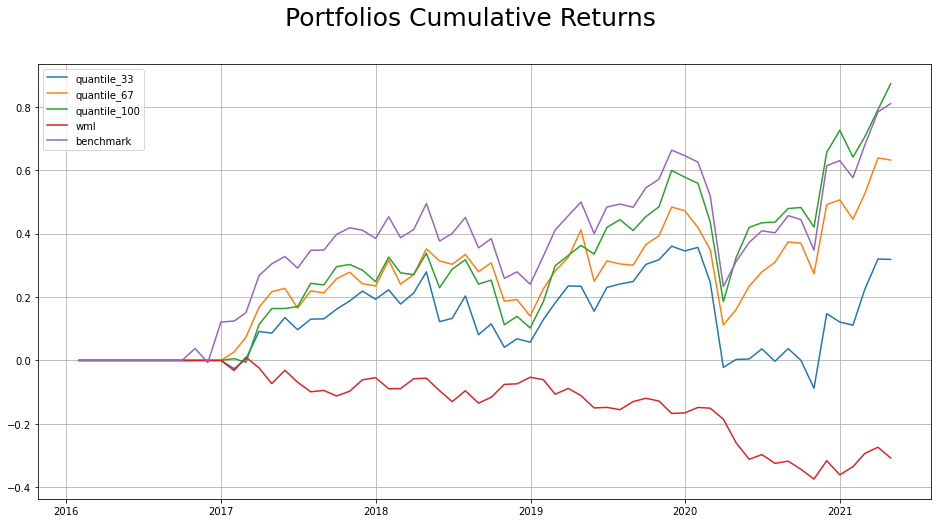

Value(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │    wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪════════╡
│ Alpha %        │         -0.53 │         -0.15 │           0.21 │  -0.74 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ Alpha t        │         -1.91 │         -0.57 │           0.82 │  -1.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ SR             │          0.21 │          0.44 │           0.68 │  -0.71 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ MR %           │          0.35 │          0.68 │           0.97 │  -0.62 │
├────────────────┼───────────────┼───────────────┼────────────────┼────────┤
│ ER %           │         -0.51 │         -0.19 │           0.11 │  -1.49 │
├────────────────┼───────────────┼───────────────┼───────────

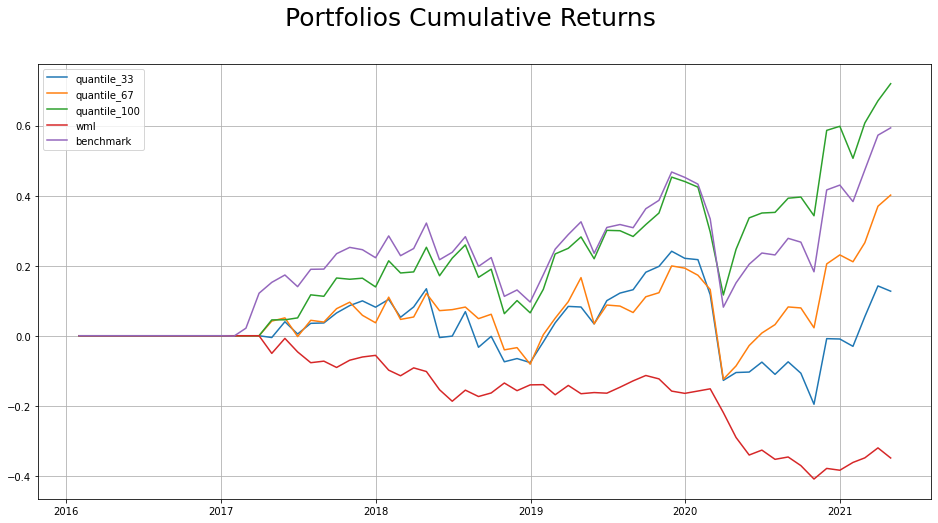

In [8]:
full_test_factor('Value', value, static=True, bigger_better=False)

Относительно фактора стоимости в классическом варианте (чем ниже `EV/EBITDA`, тем более недооценена компания) наблюдается довольно интересная картина: для всех периодов наблюдения и периодов удержания видно, что данный фактор работает с точностью до наоборот. Портфель из наиболее "дорогих" компаний показывает в среднем более высокий рост, чем индекс, в то время как портфель из наиболее "дешевых" компании оказывается худшим. Попробуем перевернуть торговую стратегию.

Reversed Value(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.36 │          0.06 │           0.41 │  0.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.24 │          0.23 │           1.58 │  1.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.42 │          0.64 │           0.86 │  0.44 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.84 │          1.05 │           1.36 │  0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.21 │         -0    │           0.31 │ -0.53 │
├────────────────┼───────────────┼───────────────┼────────────────

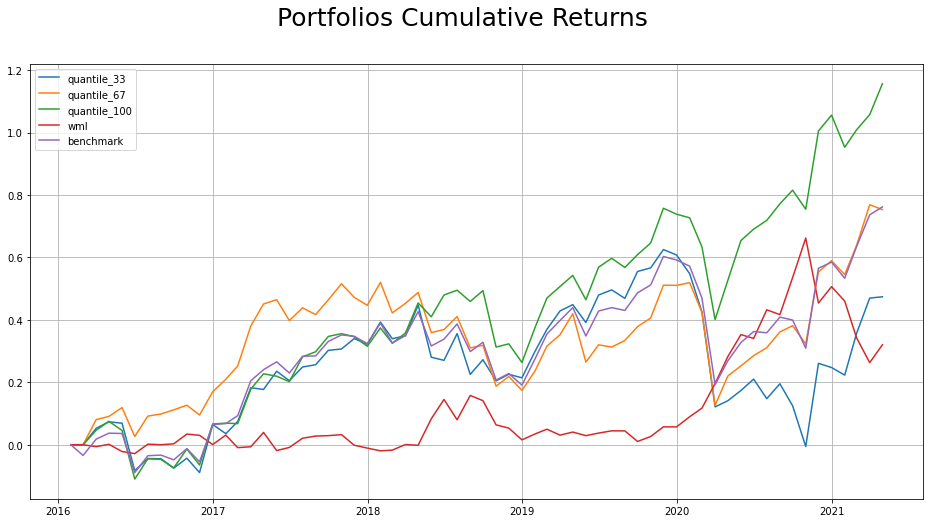

Reversed Value(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.1  │          0.04 │           0.75 │  0.85 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.27 │          0.13 │           2.55 │  1.73 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.51 │          0.59 │           1.06 │  0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1    │          0.9  │           1.56 │  0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.01 │         -0.1  │           0.56 │ -0.44 │
├────────────────┼───────────────┼───────────────┼────────────────

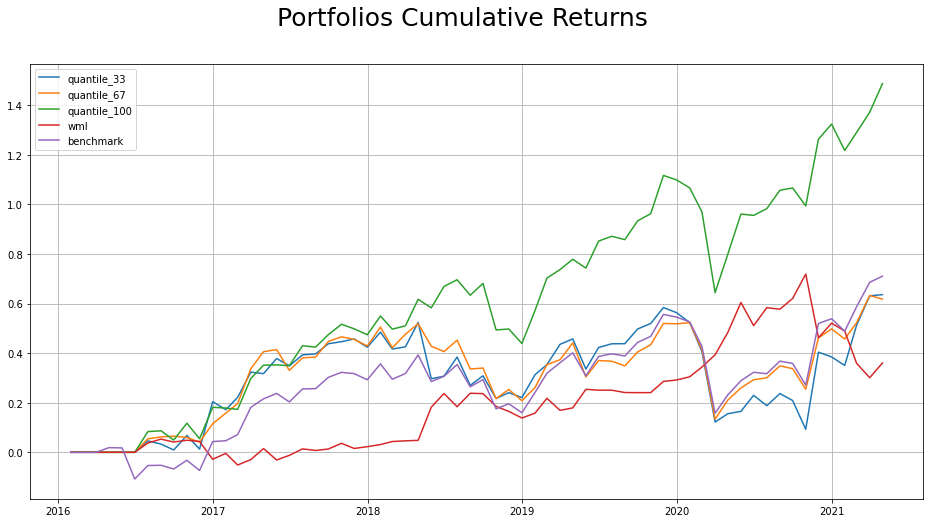

Reversed Value(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.05 │         -0.04 │           0.84 │  0.89 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.13 │         -0.13 │           2.96 │  1.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.52 │          0.52 │           1.12 │  0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.03 │          0.81 │           1.61 │  0.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.06 │         -0.17 │           0.64 │ -0.4  │
├────────────────┼───────────────┼───────────────┼────────────────

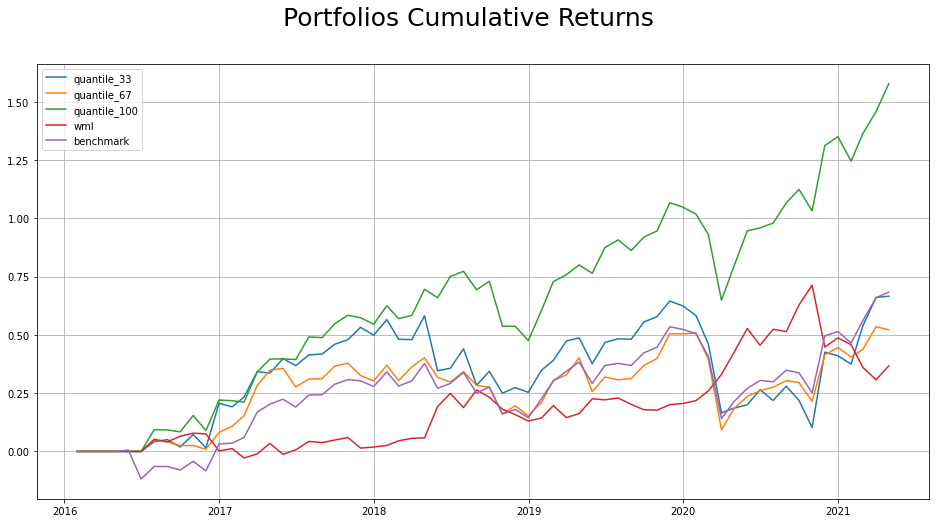

Reversed Value(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.36 │         -0.11 │           0.24 │  0.6  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.29 │         -0.5  │           1.03 │  1.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.5  │          0.63 │           0.86 │  0.49 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.91 │          0.95 │           1.36 │  0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.26 │         -0.21 │           0.2  │ -0.71 │
├────────────────┼───────────────┼───────────────┼────────────────

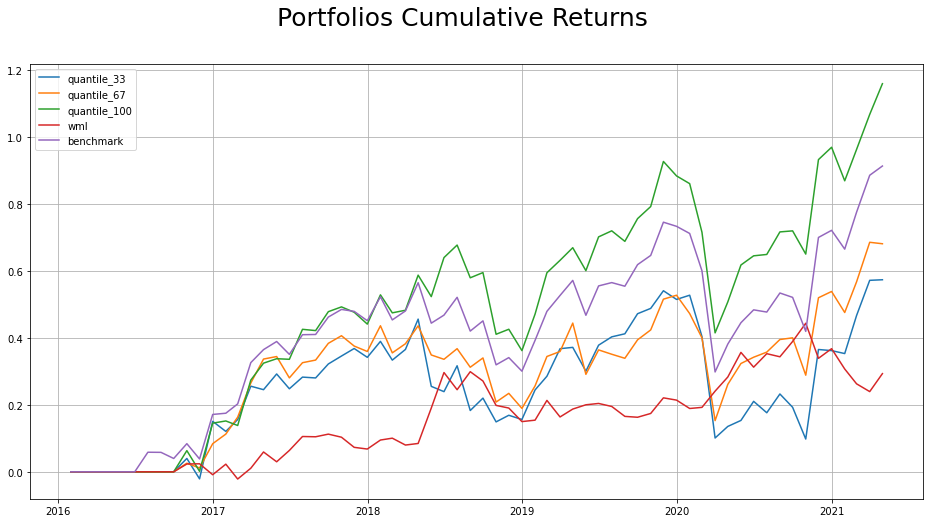

Reversed Value(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.45 │         -0.02 │           0.19 │  0.64 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.31 │         -0.06 │           0.62 │  1.47 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.36 │          0.61 │           0.74 │  0.52 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.61 │          0.9  │           1.12 │  0.51 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.47 │         -0.18 │           0.05 │ -0.56 │
├────────────────┼───────────────┼───────────────┼────────────────

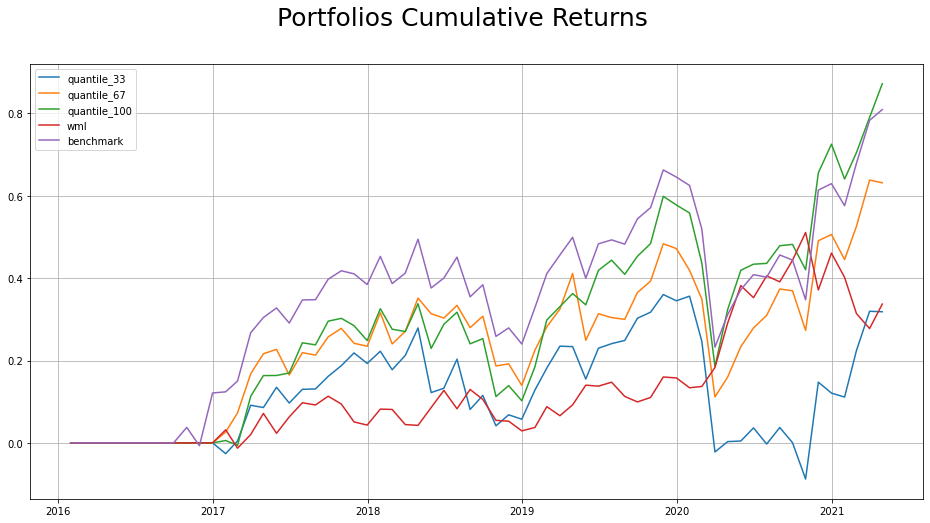

Reversed Value(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.53 │         -0.15 │           0.21 │  0.74 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.91 │         -0.57 │           0.82 │  1.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.21 │          0.44 │           0.68 │  0.71 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.35 │          0.68 │           0.97 │  0.62 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.51 │         -0.19 │           0.11 │ -0.24 │
├────────────────┼───────────────┼───────────────┼──────────────

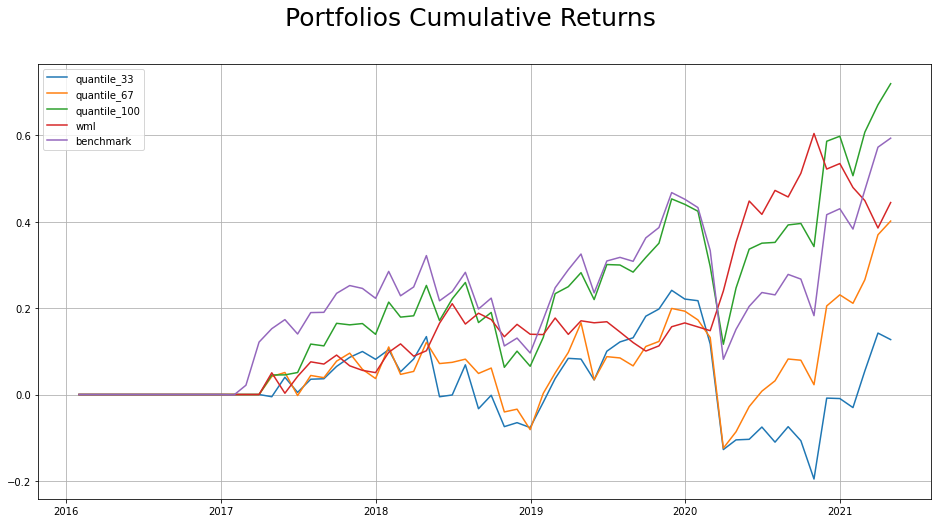

In [9]:
full_test_factor('Reversed Value', value, static=True, bigger_better=True)

Теперь уже WML-портфель показывает довольно устойчивую положительную динамику, причем с увеличением периодов наблюдения и удержания ситуация улучшается. Стоит также отметить, что WML-портфель имеет отрицательную корреляцию с индексом. Таким образом, фактор стоимости на фондовом рынке Италии скорее всего имеет место быть, однако в перевернутом варианте.

### Фактор качества

Quality(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.5  │         -0.07 │           0.8  │  1.3  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.38 │         -0.32 │           2.61 │  2.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.26 │          0.43 │           1.02 │  0.37 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.65 │          0.73 │           1.34 │  0.7  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.19 │         -0.11 │           0.51 │ -0.14 │
├────────────────┼───────────────┼───────────────┼────────────────┼──────

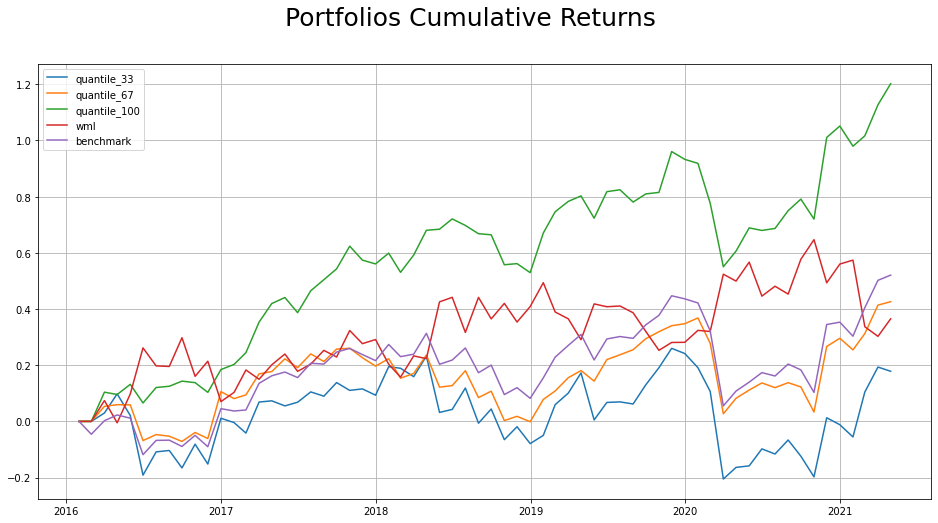

Quality(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0    │         -0.01 │           0.78 │  0.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -0.01 │         -0.04 │           2.52 │  1.34 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.43 │          0.43 │           1.02 │  0.15 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.01 │          0.71 │           1.27 │  0.26 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.2  │         -0.09 │           0.46 │ -0.55 │
├────────────────┼───────────────┼───────────────┼────────────────┼──────

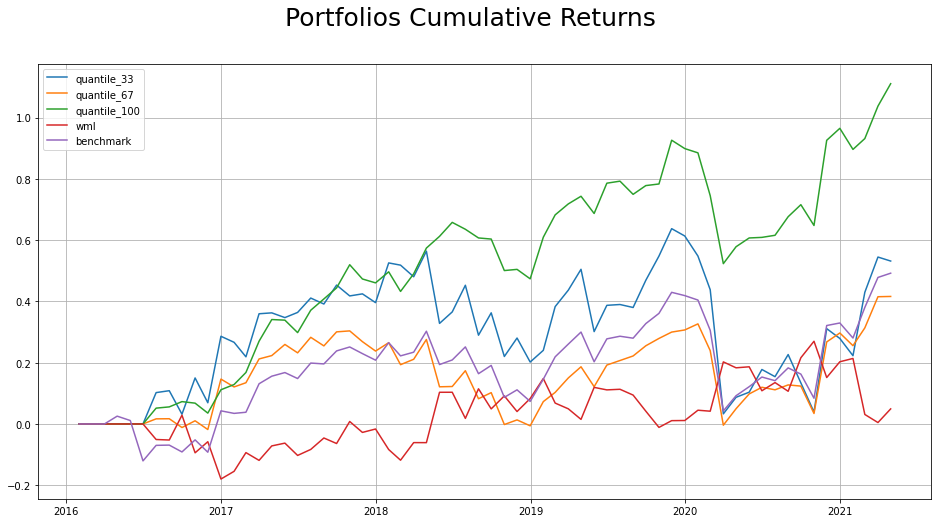

Quality(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.03 │         -0.03 │           0.8  │  0.77 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.07 │         -0.11 │           2.6  │  1.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.44 │          0.41 │           1.02 │  0.15 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.02 │          0.69 │           1.28 │  0.26 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.23 │         -0.1  │           0.49 │ -0.53 │
├────────────────┼───────────────┼───────────────┼────────────────┼──────

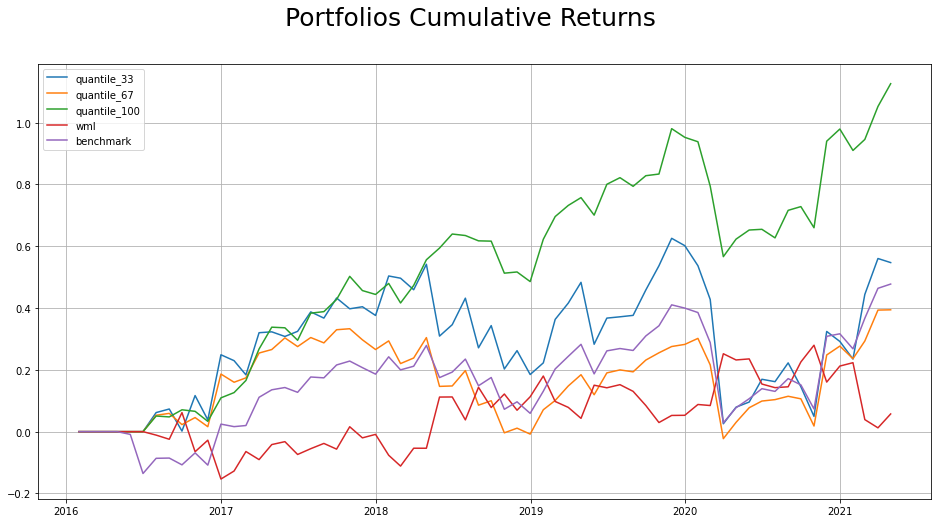

Quality(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.35 │         -0.32 │           0.5  │  0.85 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.09 │         -1.49 │           1.72 │  1.55 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.42 │          0.39 │           0.92 │  0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.97 │          0.64 │           1.14 │  0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.02 │         -0.35 │           0.14 │ -0.83 │
├────────────────┼───────────────┼───────────────┼────────────────┼──────

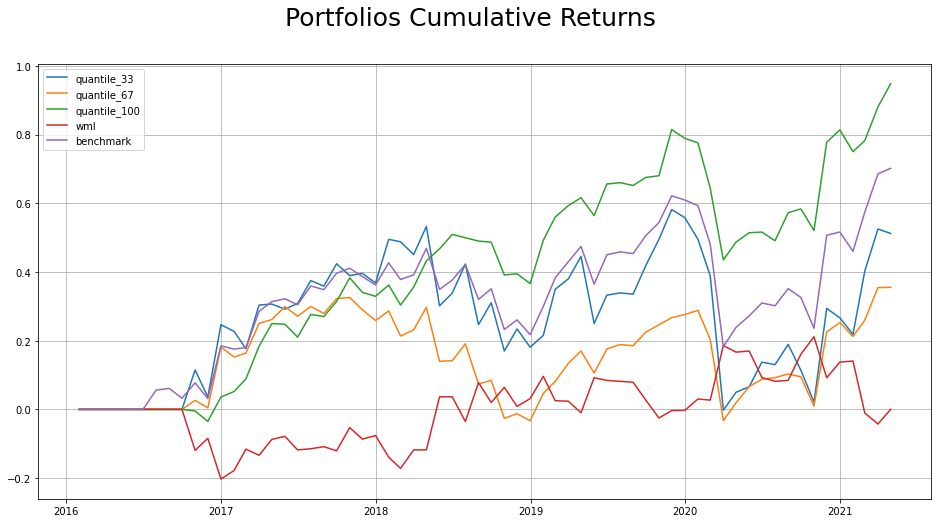

Quality(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.54 │         -0.23 │           0.37 │  0.9  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.23 │         -0.78 │           1.14 │  1.67 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.23 │          0.34 │           0.74 │  0.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.5  │          0.52 │           0.97 │  0.47 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.4  │         -0.38 │           0.07 │ -0.42 │
├────────────────┼───────────────┼───────────────┼────────────────┼──────

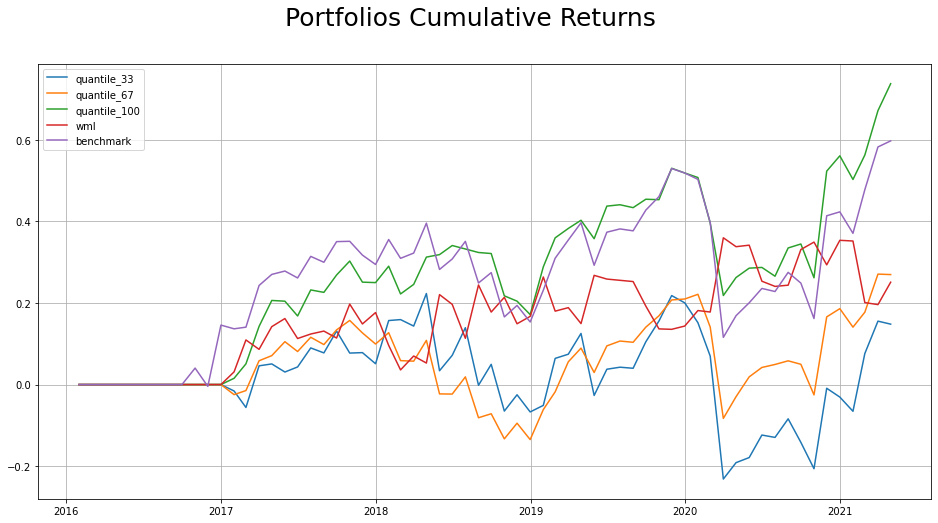

Quality(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │         -0.42 │         -0.21 │           0.39 │  0.81 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │         -1.19 │         -0.86 │           1.35 │  1.51 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.18 │          0.26 │           0.67 │  0.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.37 │          0.41 │           0.85 │  0.48 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.28 │         -0.23 │           0.2  │ -0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼────

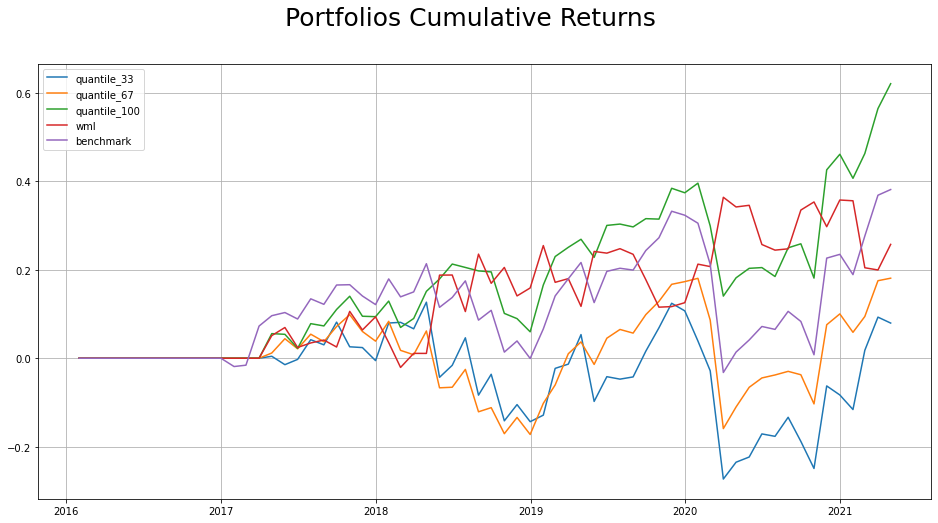

In [10]:
full_test_factor('Quality', quality, static=True, bigger_better=True)

Фактор качества на рынке Италии тоже проявляется особым образом: "winners" действительно показывают хорошую динамику лучше индекса, однако нельзя сказать, что "losers" демонстрируют сильно плохую динамику. Однако можно заметить, что с ростом периода наблюдения и периода удержания портфель из лучших компаний приближается к индексу, а портфель из худших отдаляется от него вниз. Исходя из данной динамики, можно сделать предположение, что компании с высоким `ROA` в долгосрочном периоде включают в индекс, а компании с низким `ROA` - исключают, что и может объяснять существование данного фактора на рынке Италии.

### Фактор низкой волатильности

Low Volatility(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.75 │         -0.01 │          -0.64 │  1.39 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.77 │         -0.05 │          -1.78 │  2.34 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          1.17 │          0.6  │           0.34 │  0.31 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.41 │          0.95 │           0.83 │  0.58 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.37 │         -0.09 │          -0.21 │ -0.46 │
├────────────────┼───────────────┼───────────────┼────────────────

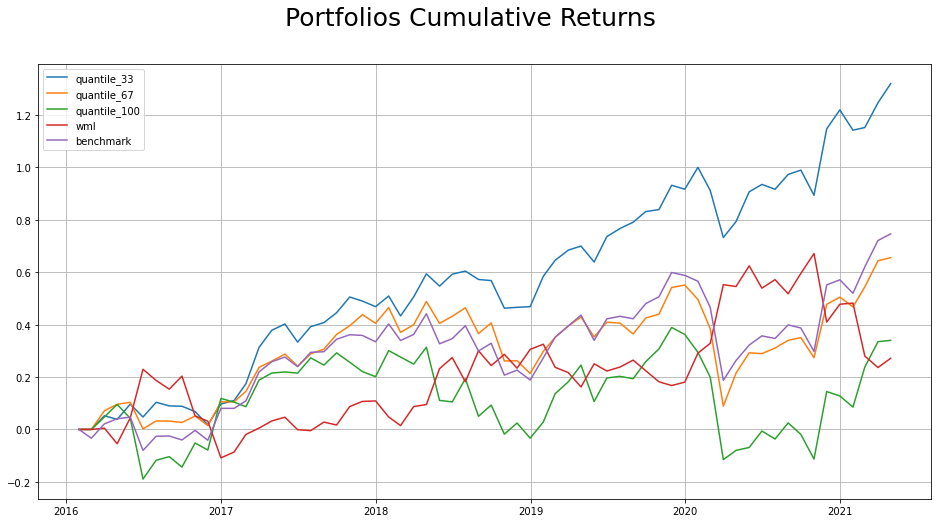

Low Volatility(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.58 │          0.15 │          -0.13 │  0.72 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.89 │          0.54 │          -0.31 │  1.18 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.97 │          0.65 │           0.49 │  0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.23 │          1.05 │           1.07 │  0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.23 │          0.05 │           0.07 │ -0.83 │
├────────────────┼───────────────┼───────────────┼────────────────

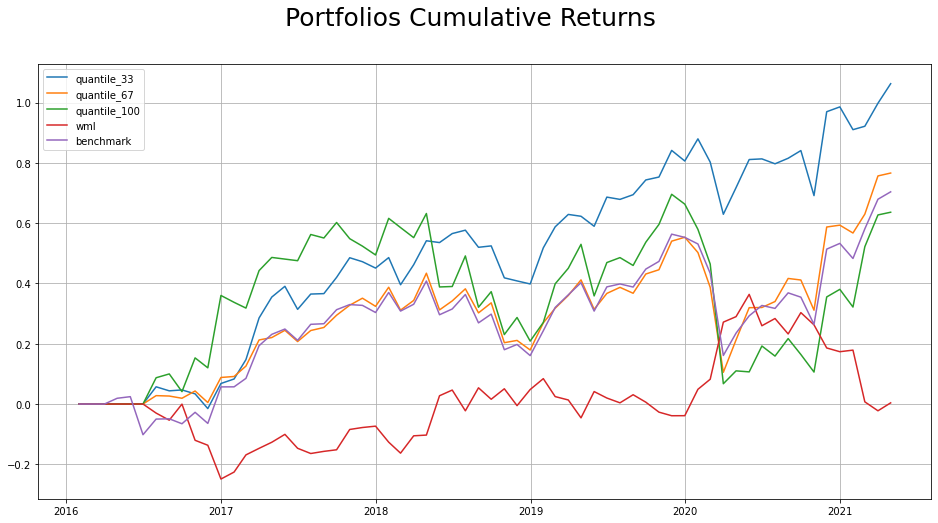

Low Volatility(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.6  │          0.32 │          -0.19 │  0.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.95 │          1.17 │          -0.44 │  1.32 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.97 │          0.74 │           0.45 │  0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.2  │          1.15 │           1.03 │  0.17 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.24 │          0.19 │           0.07 │ -0.78 │
├────────────────┼───────────────┼───────────────┼────────────────

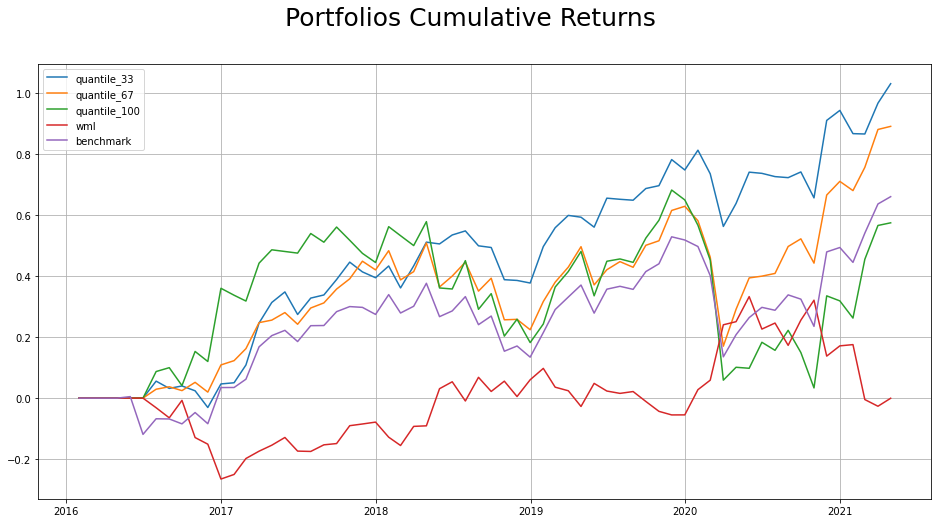

Low Volatility(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.5  │         -0.02 │          -0.63 │  1.13 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.83 │         -0.08 │          -1.74 │  1.95 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          1.03 │          0.68 │           0.4  │  0.2  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.26 │          1.02 │           0.93 │  0.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.12 │         -0.12 │          -0.21 │ -0.8  │
├────────────────┼───────────────┼───────────────┼────────────────

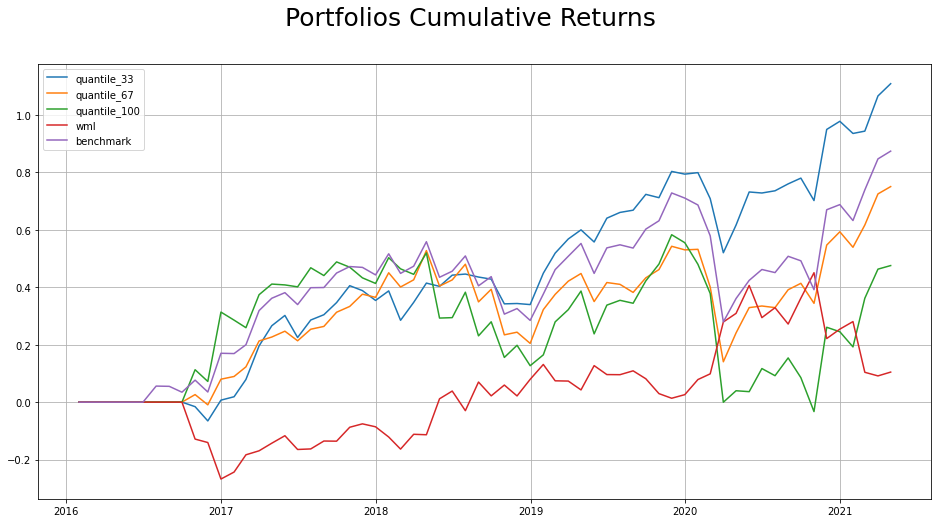

Low Volatility(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.49 │          0.03 │          -0.85 │  1.33 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.64 │          0.12 │          -2.03 │  2.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.98 │          0.64 │           0.21 │  0.47 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.15 │          0.95 │           0.43 │  0.72 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.08 │         -0.12 │          -0.64 │ -0.35 │
├────────────────┼───────────────┼───────────────┼────────────────

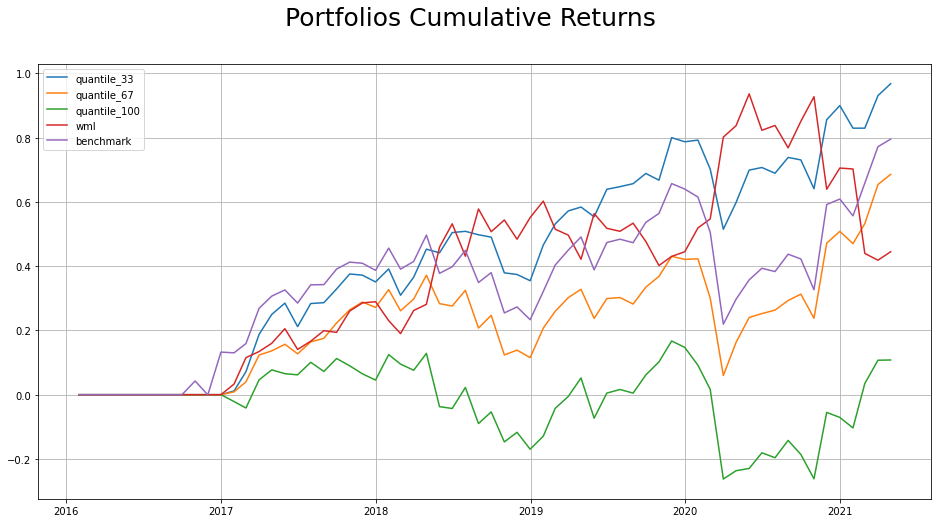

Low Volatility(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.24 │         -0.06 │          -0.7  │  0.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.95 │         -0.28 │          -2.07 │  1.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.71 │          0.5  │           0.19 │  0.29 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.8  │          0.74 │           0.39 │  0.41 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │         -0.06 │         -0.12 │          -0.47 │ -0.45 │
├────────────────┼───────────────┼───────────────┼──────────────

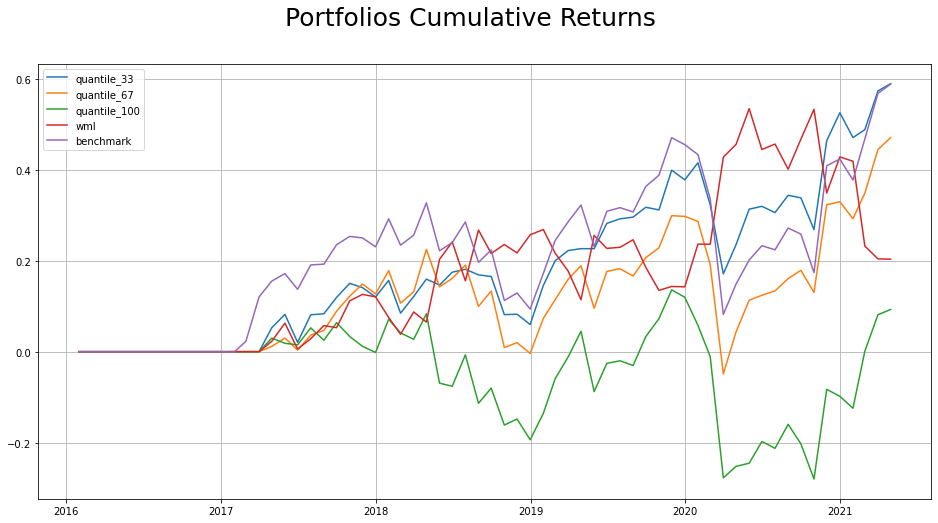

In [11]:
full_test_factor('Low Volatility', low_volatility, static=True, bigger_better=False)

Фактор низкой волатильности начинает проявлять себя при увеличении периодов наблюдения и удержания: с ростом данных параметром компании, имеющие наибольшее значение $\beta$-коэффициента, начинают сильнее отставать от индекса, в то время как компании с наибольшим значением $\beta$-коэффициента, наоборот, приближаются к индексу, из-за чего динамика WML-портфеля похожа на динамику WML-портфеля для фактора качества. В данном случае такая динамика опять же может объясняться тем, что компании с низкой бетой в долгосрочном включают в индексы, с высокой - исключают (либо же появляются новые компании, которые еще не включены в индекс).

### Фактор размера

Size(1-0-1)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.43 │         -0.04 │          -0.29 │  0.72 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.2  │         -0.22 │          -1.67 │  2.37 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.85 │          0.59 │           0.43 │  1.23 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.61 │          0.93 │           0.67 │  0.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.56 │         -0.12 │          -0.38 │ -0.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤


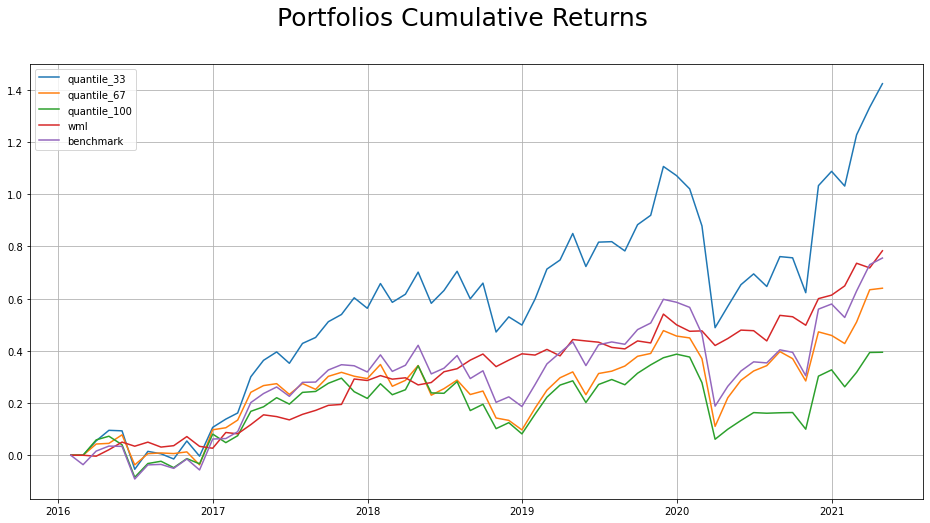

Size(3-0-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.64 │          0.17 │          -0.13 │  0.76 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.29 │          0.67 │          -0.54 │  2.51 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.94 │          0.68 │           0.49 │  1.28 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.66 │          1.07 │           0.72 │  0.94 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.65 │          0.06 │          -0.29 │ -0.06 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤


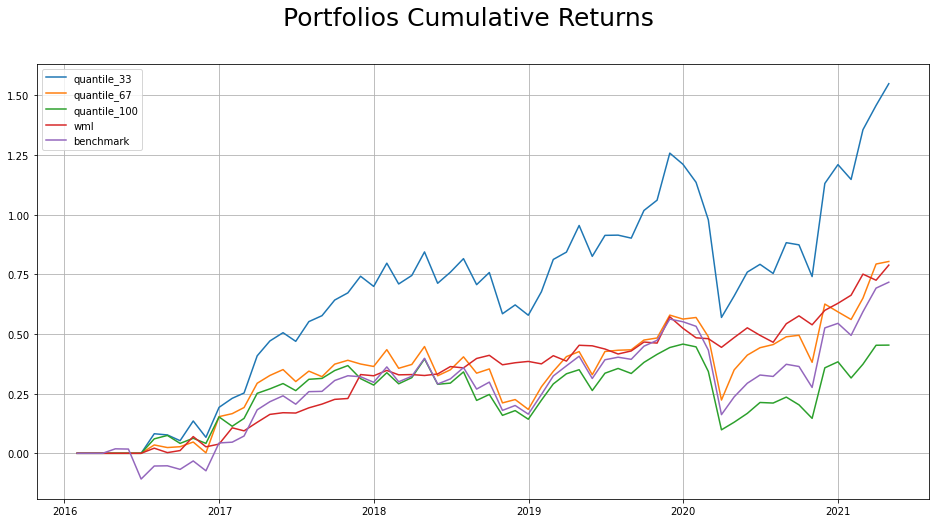

Size(3-1-3)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.57 │          0.23 │          -0.05 │  0.61 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          2.06 │          0.96 │          -0.19 │  2.08 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.87 │          0.71 │           0.53 │  1.09 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.59 │          1.05 │           0.8  │  0.79 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.62 │          0.08 │          -0.18 │ -0.18 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤


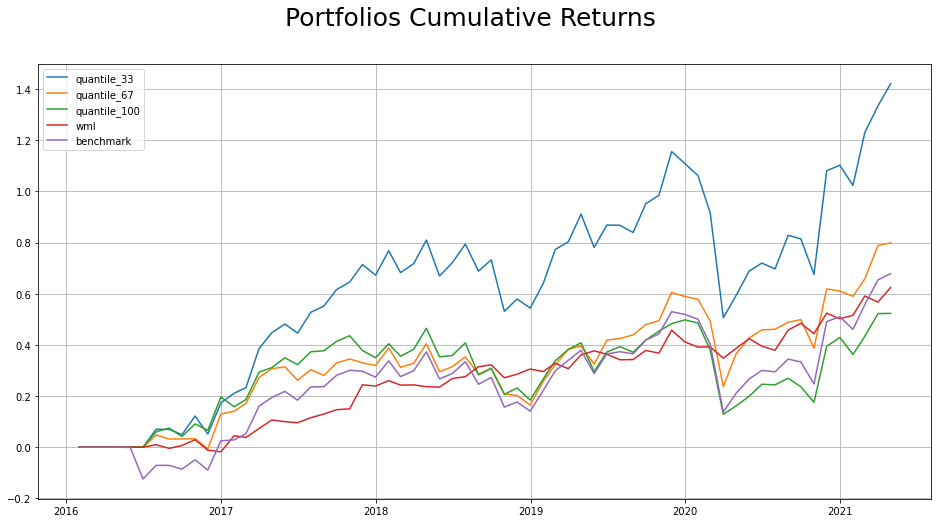

Size(6-0-6)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.27 │         -0.14 │          -0.37 │  0.64 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          1.42 │         -0.75 │          -1.83 │  2.27 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.88 │          0.62 │           0.49 │  1.21 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.57 │          0.87 │           0.77 │  0.8  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.4  │         -0.3  │          -0.41 │ -0.37 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤


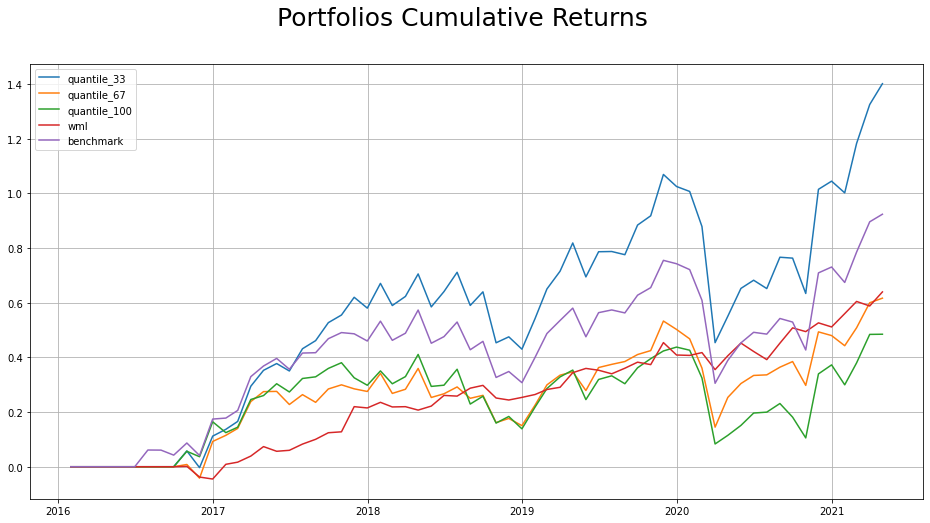

Size(9-0-9)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.15 │         -0.06 │          -0.42 │  0.57 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.52 │         -0.26 │          -1.53 │  2.07 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.74 │          0.59 │           0.36 │  1.1  │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          1.25 │          0.8  │           0.54 │  0.71 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.16 │         -0.29 │          -0.54 │ -0.38 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤


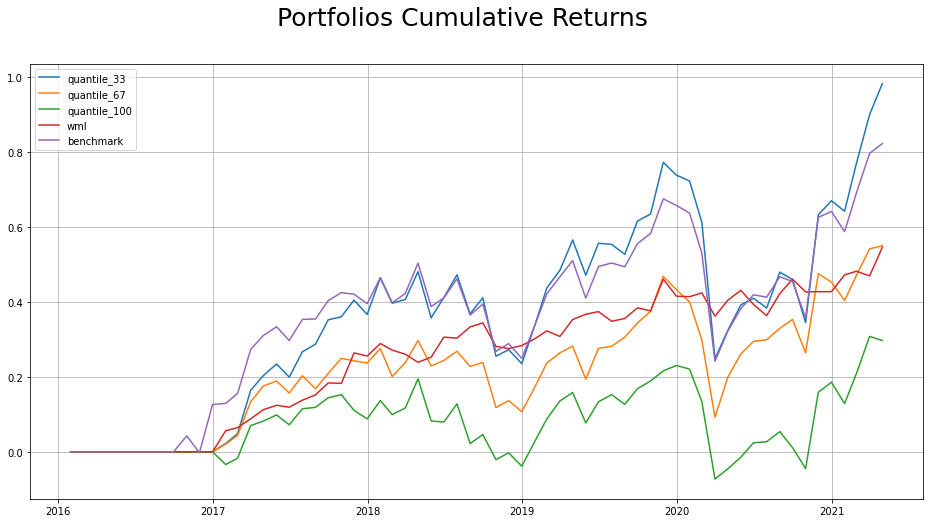

Size(12-0-12)
╒════════════════╤═══════════════╤═══════════════╤════════════════╤═══════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │   wml │
╞════════════════╪═══════════════╪═══════════════╪════════════════╪═══════╡
│ Alpha %        │          0.06 │         -0.16 │          -0.4  │  0.45 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ Alpha t        │          0.24 │         -0.78 │          -1.78 │  1.69 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ SR             │          0.59 │          0.43 │           0.29 │  0.88 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ MR %           │          0.98 │          0.56 │           0.43 │  0.55 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────┤
│ ER %           │          0.11 │         -0.31 │          -0.44 │ -0.32 │
├────────────────┼───────────────┼───────────────┼────────────────┼───────

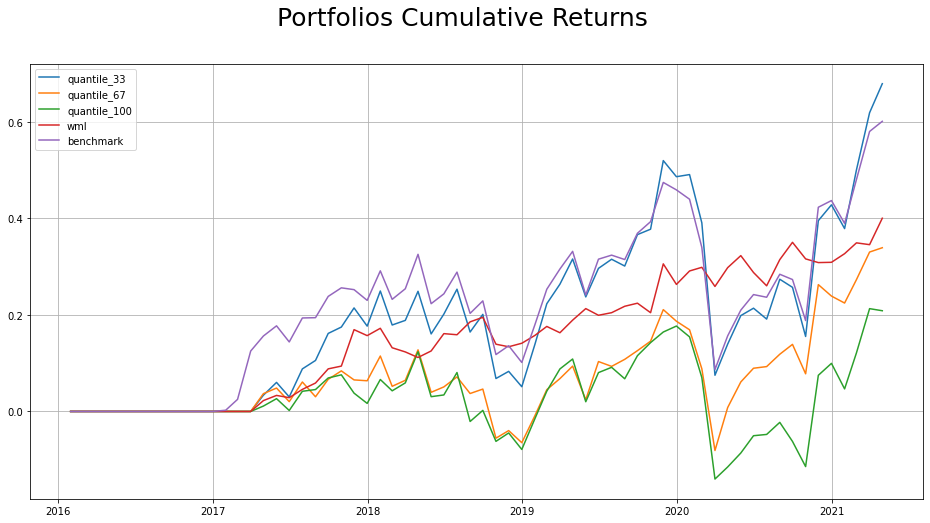

In [12]:
full_test_factor('Size', size, static=True, bigger_better=False)

Исходя из графиков кумулятивной доходности портфелей можно сделать практически такие же выводы, как для факторов качества и низкой волатильности: опять "лучшие" компании согласно фактору показывают лучшую динамику при маленьких значениях периодов наблюдения и удержания, а с их ростом приближаются к индексу, в то время как "худшие" - изначально близки к индексу, а с ростом параметров сильнее отдаляются от него.

Таким образом, можно сделать вывод, что моментум-фактор скорее отсуствует на итальянском фондовом рынке, портфели, основанные на факторах качества, низкой волатильности и размера, имеют очень похожее поведение, а фактор стоимости вообще удивляет - он достаточно эффективно работает, но в перевернутом варианте.

# Проверка статистической значимости факторных стратегий

Для начала отберем для каждого фактора параметры, при которых коэффициент Шарпа WML-портфеля максимален:
* Reversed Value(12-0-12) `SR = 0.71`
* Quality(1-0-1) `SR = 0.37`
* Low Volatility(9-0-9) `SR = 0.47`
* Size(3-0-3) `SR = 1.28`

In [13]:
def stats_for_wml(results):
    wml_returns = np.nansum(results[0][-1], axis=1)
    benchmark_returns = np.nansum(results[1], axis=1)
    
    ttest = ttest_1samp(wml_returns, 0)
    w, p = wilcoxon(wml_returns)
    
    stats = {
        't-stat': ttest.statistic,
        't-stat p-value': ttest.pvalue,
        'wilcoxon': w,
        'wilcoxon p-value': p
    }
    
    print(
        tabulate(
            pd.DataFrame(stats, index=['value']).transpose().round(2),
            tablefmt='fancy_grid'
        )
    )

## Перевернутый фактор стоимости

In [14]:
reversed_value_results = test_factor(value, static=True, 
                                     looking=12, lag=0, holding=12,
                                     add_wml=True, bigger_better=True,
                                     only_portfolio_and_benchmark=True)
stats_for_wml(reversed_value_results)

╒══════════════════╤════════╕
│ t-stat           │   1.62 │
├──────────────────┼────────┤
│ t-stat p-value   │   0.11 │
├──────────────────┼────────┤
│ wilcoxon         │ 480    │
├──────────────────┼────────┤
│ wilcoxon p-value │   0.19 │
╘══════════════════╧════════╛


Можно сказать, что статистическая значимость доходности WML-портфеля для перевернутого фактора стоимости достаточно высока (почти с 90% вероятностью можно это утверждать), однако тест Вилкоксона имеет меньшую статистическую значимость, поэтому говорить о том, что медиана разностей положительна можно только с почти 80% вероятностью. Нельзя с высокой уверенностью говорить о том, что данный фактор присутствует на рынке Италии, тем не менее, WML-портфель имеет один из самых высоких коэффициентов Шарпа среди отобранных, поэтому будем считать, что данный парадоксальный фактор действительно есть на рынке Италии.

## Фактор качества

In [15]:
quality_results = test_factor(quality, static=True, 
                              looking=1, lag=0, holding=1,
                              add_wml=True, bigger_better=True,
                              only_portfolio_and_benchmark=True)
stats_for_wml(quality_results)

╒══════════════════╤════════╕
│ t-stat           │   0.85 │
├──────────────────┼────────┤
│ t-stat p-value   │   0.4  │
├──────────────────┼────────┤
│ wilcoxon         │ 881    │
├──────────────────┼────────┤
│ wilcoxon p-value │   0.5  │
╘══════════════════╧════════╛


Статистическая значимость и положительной доходности портфеля, и гипотезы о положительной разнице медиан слишком низкая для того, чтобы можно было это утверждать. Фактор качества скорее всего отсутствует на фондовом рынке Италии.

## Фактор низкой волатильности

In [16]:
low_volatility_results = test_factor(low_volatility, static=True, 
                                     looking=9, lag=0, holding=9,
                                     add_wml=True, bigger_better=False,
                                     only_portfolio_and_benchmark=True)
stats_for_wml(low_volatility_results)

╒══════════════════╤════════╕
│ t-stat           │   1.08 │
├──────────────────┼────────┤
│ t-stat p-value   │   0.28 │
├──────────────────┼────────┤
│ wilcoxon         │ 550    │
├──────────────────┼────────┤
│ wilcoxon p-value │   0.21 │
╘══════════════════╧════════╛


Статистическая значимость доходности WML-портфеля для фактора низкой волатильности довольно низкая, тест Вилкоксона имеет также имеет не очень высокую статистическую значимость, поэтому говорить о том, что медиана разностей положительна можно только с почти 80% вероятностью. Присутствие фактора на рынке остается под вопросом.

## Фактор размера

In [17]:
size_results = test_factor(size, static=True, 
                           looking=3, lag=0, holding=3,
                           add_wml=True, bigger_better=False,
                           only_portfolio_and_benchmark=True)
stats_for_wml(size_results)

╒══════════════════╤════════╕
│ t-stat           │   2.92 │
├──────────────────┼────────┤
│ t-stat p-value   │   0    │
├──────────────────┼────────┤
│ wilcoxon         │ 531    │
├──────────────────┼────────┤
│ wilcoxon p-value │   0.01 │
╘══════════════════╧════════╛


Фактор размера оказался "самым значимым" среди остальных, при этом он имеет очень высокие показатели как для теста на положительную доходность, так и для теста Вилкоксона. Таким образом, можно утверждать, что фактор размера на рынке Италии имеет место быть.

# Построение факторной стратегии на основе проведенного анализа факторов

## Тестирование наиболее успешных факторных моделей с учетом фильтра ликвидности

Мы поняли, что на рынке Италии с высокой вероятностью существует фактор размера и, с менее высокой, - перевернутый фактор стоимости. Теперь попробуем сделать более реалистичный портфель с помощью этих факторов, но для этого будем рассматривать только long-only портфели, т.к. на практике реализовать WML-портфель вряд ли удастся. Отбор также произведем по коэффициенту Шарпа: 
* Reversed Value(3-1-3) `SR = 1.12`
* Size(3-0-3) `SR = 0.94`

В качестве фильтра ликвидности возьмем среднемесячный объем торгов внутри 1 торгового дня, который рассчитывается как $Avg.Trad.Volume_{daily} = \frac{Tot.Volume_{monthly} \cdot Close_{monthly}}{N}$, где $N$ - число дней в месяце. 

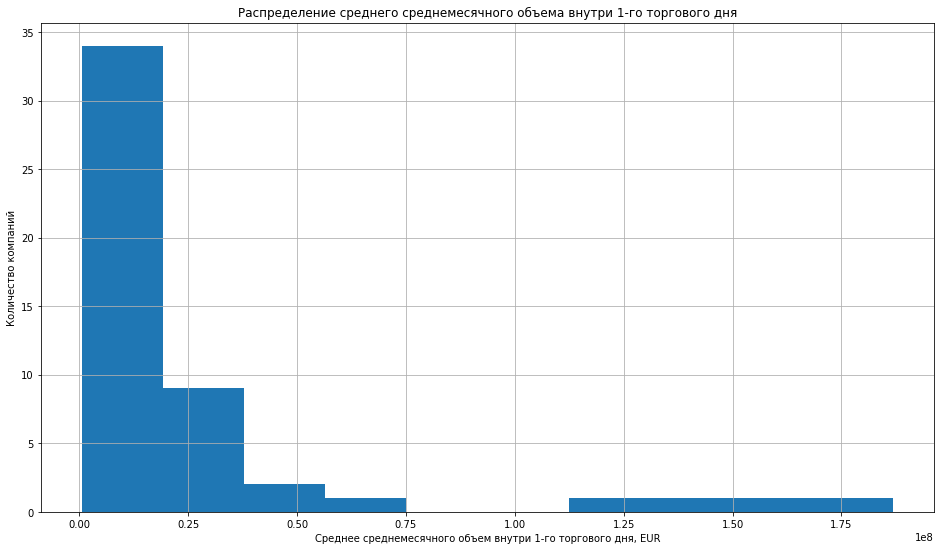

In [18]:
trading_volume.mean().hist()
plt.title('Распределение среднего среднемесячного объема внутри 1-го торгового дня')
plt.xlabel('Среднее среднемесячного объем внутри 1-го торгового дня, EUR')
plt.ylabel('Количество компаний')
plt.show()

По графику распределения среднего среднемесячного объема торгов внутри 1-го дня видно, что большая часть итальянских компаний не обладает очень высокой ликвидность. Было решено взять границу около первого бина как минимальное значение данного параметра, т.е. 2 500 000 EUR.

In [19]:
liquidity_threshold = 2_500_000

### Перевернутый фактор стоимости

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │         -0.11 │          0.19 │           0.93 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │         -0.29 │          0.61 │           3.27 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.37 │          0.54 │           1.06 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          0.77 │          0.83 │           1.54 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │         -0.02 │          0.04 │           0.76 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         39.22 │         54.6  │         145.92 │
├────────────────┼───────────────┼──────────────

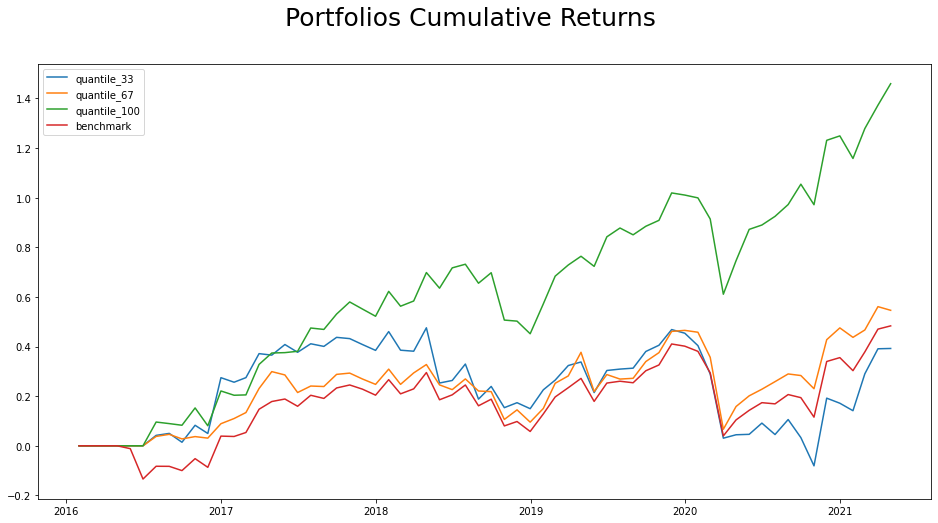

In [20]:
value_results = test_factor(value, static=True, 
                            looking=3, lag=1, holding=3, 
                            filter_factor=trading_volume, min_threshold=liquidity_threshold)

### Фактор размера

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.4  │          0.66 │          -0.13 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          1.34 │          2.69 │          -0.51 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.68 │          0.91 │           0.37 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          1.22 │          1.32 │           0.59 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.41 │          0.51 │          -0.22 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         91.82 │        113.69 │          32.35 │
├────────────────┼───────────────┼──────────────

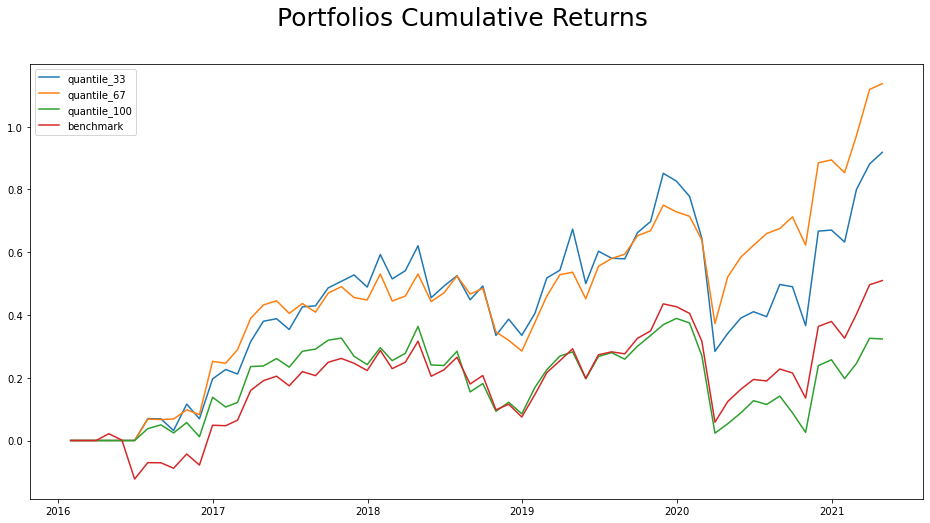

In [21]:
size_results = test_factor(size, static=True, 
                           looking=3, lag=0, holding=3, 
                           filter_factor=trading_volume, min_threshold=liquidity_threshold)

Как видно из графиков и таблицы метрик качества работы стратегии, введение фильтра по ликвидности не очень сильно повлияло на показатели факторной стратегии на основе перевернутого фактора стоимости, но все-таки немного ухудшило их. Однако для фактора размера коэффициент Шарпа сильно упал, что неудивительно - маленькие компании обычно не имеют большого торгового оборота, а данная стратегия именно на них и ориентированна.

## Объединение наиболее успешных факторов в мультифакторную модель

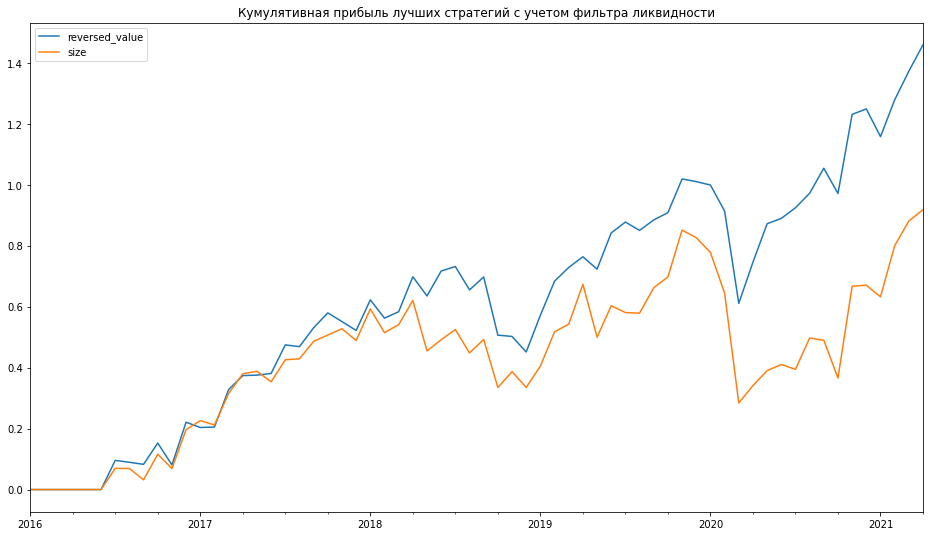

In [22]:
results = pd.DataFrame(
    {'reversed_value': value_results[6][-2],
     'size': size_results[6][0]},
    index=prices.index
)

results.plot()
plt.title('Кумулятивная прибыль лучших стратегий с учетом фильтра ликвидности')
plt.show()

In [23]:
results.corr()

reversed_value     size
reversed_value         1.00000  0.90124
size                   0.90124  1.00000

Как видно из графика накопленной доходности и таблицы корреляций, фактор размера и перевернутый фактор стоимости имеют довольно высокую корреляцию, поэтому не имеет особого смысла собирать из них полноценную мультифакторную модель. Поэтому возьмем перевернутый фактор стоимости как основной, т.к. он имеет более высокий коэффициент Шарпа, который не так сильно пострадал после введения фильтра ликвидности, а фактор размера возьмем как побочный - для развесовки. Для того, чтобы более мелким компаниям давать больший вес, а более крупным - меньший, возьмем обратную функцию: $\frac{1}{Market Cap}$.

╒════════════════╤═══════════════╤═══════════════╤════════════════╕
│                │   quantile_33 │   quantile_67 │   quantile_100 │
╞════════════════╪═══════════════╪═══════════════╪════════════════╡
│ Alpha %        │          0.08 │          0.26 │           1.06 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ Alpha t        │          0.17 │          0.68 │           2.94 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ SR             │          0.45 │          0.56 │           1.05 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ MR %           │          0.97 │          0.97 │           1.75 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ ER %           │          0.19 │          0.19 │           0.97 │
├────────────────┼───────────────┼───────────────┼────────────────┤
│ TR %           │         56.69 │         65.01 │         173.41 │
├────────────────┼───────────────┼──────────────

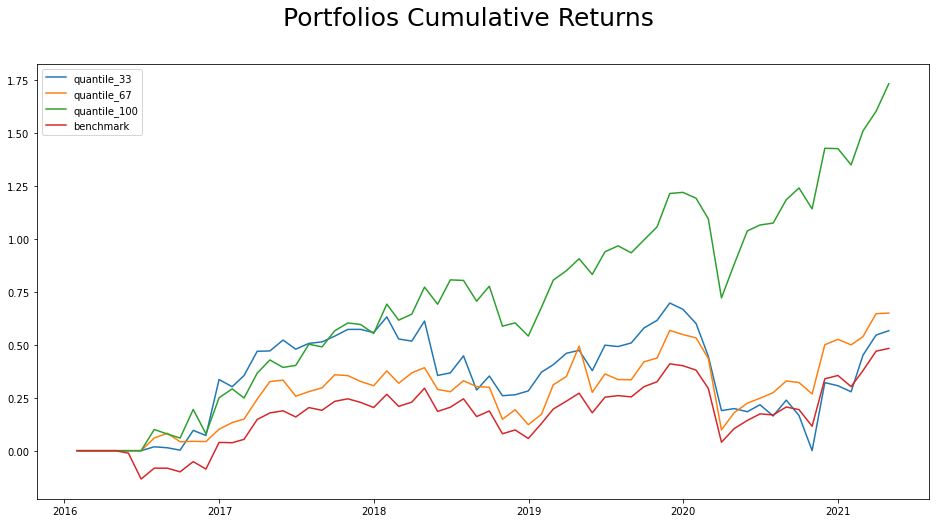

In [24]:
factor = get_factor(value, static=True, looking_period=3, lag=1)
factor = set_stock_universe(factor, trading_volume, min_threshold=liquidity_threshold)

positions, names = get_all_quantiles(factor, quantile_step=quantile_step, 
                                     holding_period=3, static=True)
portfolio = set_value_weights(positions, 1 / size)
fee = get_fee_costs(portfolio, fee_rate=fee_rate)

universe_return = get_universe_return(prices)
portfolio_return = get_portfolio_return(portfolio, universe_return, fee_lists=fee)
benchmark_return = get_benchmark(prices, factor, universe_return, equal_weights=True)

result = compare_portfolios(names, portfolio_return, benchmark_return, prices.index)

За счет комбинации стратегий незначительно упал коэффициент Шарпа (относительно стратегии только на основе перевернутого фактора стоимости), но при этом выросла $\alpha$ и общая прибыль. Проверим статистическую значимость гипотезы о том, что избыточная доходность больше нуля.

In [25]:
returns = np.nansum(portfolio_return[-1], axis=1)
benchmark = np.nansum(benchmark_return, axis=1)
excessive_returns = returns - benchmark

ttest = ttest_1samp(excessive_returns, 0)
w, p = wilcoxon(excessive_returns)

stats = {
    't-stat': ttest.statistic,
    't-stat p-value': ttest.pvalue,
    'wilcoxon': w,
    'wilcoxon p-value': p
}

print(
    tabulate(
        pd.DataFrame(stats, index=['value']).transpose().round(2),
        tablefmt='fancy_grid'
    )
)

╒══════════════════╤════════╕
│ t-stat           │   2.66 │
├──────────────────┼────────┤
│ t-stat p-value   │   0.01 │
├──────────────────┼────────┤
│ wilcoxon         │ 496    │
├──────────────────┼────────┤
│ wilcoxon p-value │   0    │
╘══════════════════╧════════╛


С достаточно высокой вероятностью (99%) можно утверждать, что избыточная доходность портфеля больше нуля неслучайным образом, что также подтверждает и тест Вилконсона.